In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [3]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [4]:

def get_tagged_users(df):
    """get all @ in the messages"""

    return df['msg_content'].map(lambda x: re.findall(r'@U\w+', x))


    
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

In [34]:
def get_top_N_user(data,n, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:n].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top {n} Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-n:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom {n} Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def get_top_N_user_by_reply_count(data,n, channel='Random'):
    """get user with the highest number of reply count in a channel"""

    data.groupby('sender_name')[['reply_count']].sum().sort_values(by='reply_count',ascending=False)\
    [:n].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top {n} Message Senders in #{channel} channels by reply count', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data.groupby('sender_name')[['reply_count']].sum().sort_values(by='reply_count',ascending=False)\
    [-n:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom {n} Message Senders in #{channel} channels by reply count', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def get_top_N_user_by_reaction_count(data,n, channel='Random'):
    """get user with the highest number of reply count in a channel"""

    data.groupby('real_name')[['reaction_count']].sum().sort_values(by='reaction_count',ascending=False)\
    [:n].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top {n} Reactions in #{channel} channels by reply count', size=15, fontweight='bold')
    plt.xlabel("User Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data.groupby('real_name')[['reply_count']].sum().sort_values(by='reaction_count',ascending=False)\
    [-n:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom {n} Reactions in #{channel} channels by reaction count', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()
def plot_2d_scatter_plot(x,y):
    fig, ax = plt.subplots()
    ax.scatter(x,y)
    ax.set_title('Channel Message to Reply Count Plot')
    ax.set_xlabel('Channel msg Count')
    ax.set_ylabel('Channel reply Count')

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [6]:
# Visualize reply counts per user per channel

In [ ]:
# which user has the highest number of reply counts?
slack_loader = SlackDataLoader(f'../anonymized/')
channels = slack_loader.get_channels()
# Iterate through names from channels and feed it to slack loader
dfList = []
x = []
y = []
for channel in channels:
    df = slack_loader.slack_parser(channel['name'])
    x.append(len(df))
    y.append(df['reply_count'].sum())
    dfList.append(df)
joinedDf = pd.concat(dfList)

# Get 10 top and 10 bottom messages count by sender name
get_top_N_user(joinedDf,10)

# Get top N users by reply count
get_top_N_user_by_reply_count(joinedDf,10)

#Draw user reactions
draw_user_reaction(joinedDf)
#Plot a 2D Scatter with Channel Message Count and Reply count
plot_2d_scatter_plot(x,y)


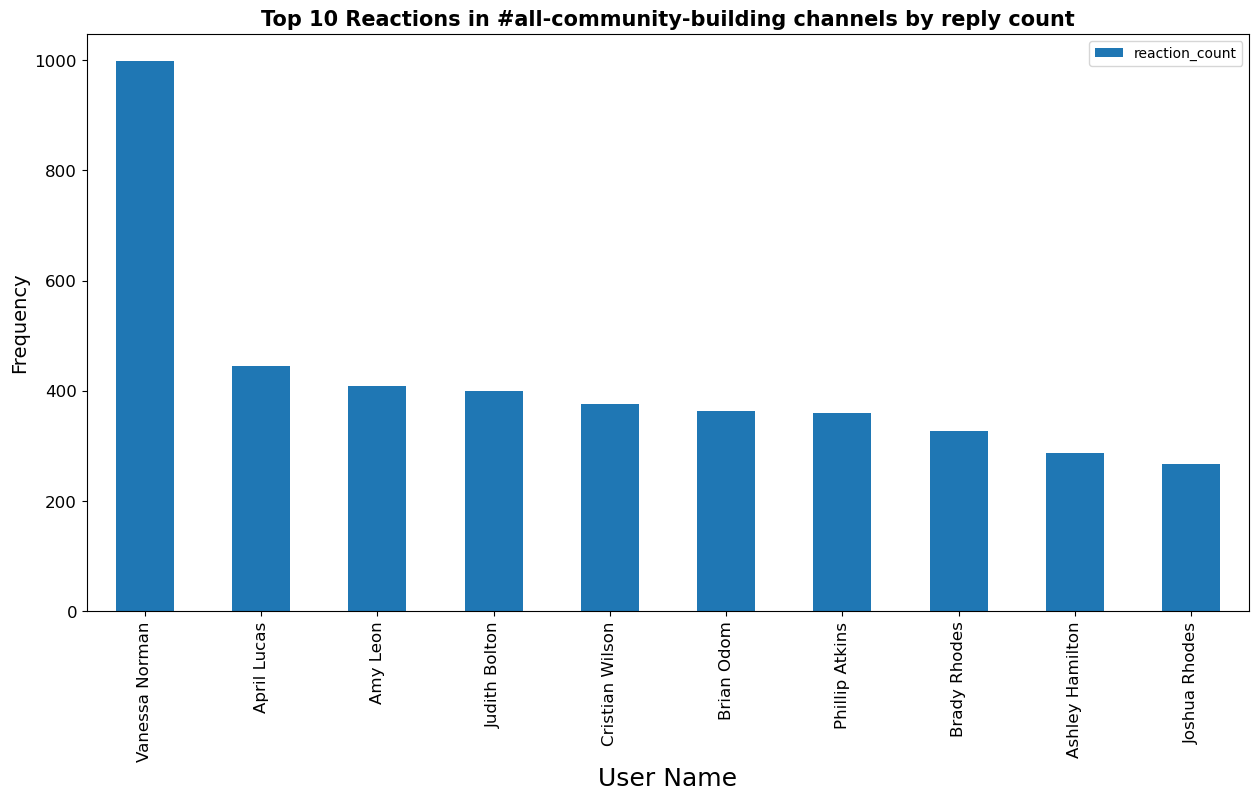

KeyError: "Columns not found: 'reply_count'"

In [36]:

#get channel reactions and top reaction count by user
react = slack_loader.parse_slack_reaction(channels[0]['name'])
users = slack_loader.get_users()

users_df = slack_loader.get_users_df(users)
# users_df
df_left = pd.merge(react,users_df,left_on='user_id',right_on='id',how='left')
get_top_N_user_by_reaction_count(df_left,10,channel=channels[0]['name'])




In [ ]:
# what kind of messages are replied faster than others?

In [ ]:
# Relationship between # of messages and # of reactions

In [ ]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [ ]:
# Which users got the most reactions?

In [ ]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?